In [1]:
# Necessary to not clog the output for pdf
import warnings
from scipy.sparse import SparseEfficiencyWarning

warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=RuntimeWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=SparseEfficiencyWarning)

In [2]:
import numpy as np
import pandas as pd

import sys
import os

# Absolute path to the utils directory
utils_path = os.path.abspath(r".\utils")

# Add it to sys.path
if utils_path not in sys.path:
    sys.path.append(utils_path)

In [3]:
# Loading the views

# Load all sheets from the Excel file
xls_path = r"..\Datasets\Final Datasets\subnationalindicatorsdataset.xlsx"
all_views = pd.read_excel(xls_path, sheet_name=None)

# Convert sheet names to lowercase keys and assign to variables
views = {}
for sheet_name, df in all_views.items():
    key = sheet_name.lower()
    views[key] = df
    globals()[f"{key}_df"] = df

# Remove the 'spatial' view if it exists
views.pop("spatial", None)

print(views)

{'economic':      Area Code         Area Level                  Area  \
0    E06000001  Unitary Authority            Hartlepool   
1    E06000002  Unitary Authority         Middlesbrough   
2    E06000003  Unitary Authority  Redcar and Cleveland   
3    E06000004  Unitary Authority      Stockton-on-Tees   
4    E06000005  Unitary Authority            Darlington   
..         ...                ...                   ...   
304  E09000029     London Borough                Sutton   
305  E09000030     London Borough         Tower Hamlets   
306  E09000031     London Borough        Waltham Forest   
307  E09000032     London Borough            Wandsworth   
308  E09000033     London Borough           Westminster   

     Gross Value Added (GVA) per hour worked (£) Gross median weekly pay (£)  \
0                                          31.85                       487.4   
1                                          30.96                       420.8   
2                                     

In [4]:
# Constants
META_COLS = ['Area Code', 'Area', 'Area Level']

ONS_EXCLUSIONS = {
    'economic': ['E06000053', 'E09000001'],
    'connectivity': ['E06000053', 'E06000057', 'E06000058', 'E06000059',
                     'E06000060', 'E06000061', 'E06000062', 'E08000037'],
    'educational_attainment': ['E06000017', 'E06000053', 'E06000060',
                                'E06000061', 'E06000062', 'E09000001'],
    'skills': ['E06000053', 'E07000166', 'E09000001'],
    'health': ['E06000022', 'E06000049', 'E06000050', 'E06000053', 'E06000060',
               'E06000061', 'E06000062', 'E07000234', 'E07000236', 'E07000237',
               'E07000238', 'E07000239', 'E08000001', 'E08000002', 'E09000001',
               'E09000010', 'E09000025', 'E09000032'],
    'wellbeing': ['E06000053', 'E09000001']
} 

# Known optimal number of clusters per view (ONS-determined)

ONS_K_VALUES = {
    'economic': 4,
    'connectivity': 4,
    'educational_attainment': 8,
    'skills': 4,
    'health': 4,
    'wellbeing': 4
}

# Preprocessing

In [5]:
from data_preprocessing import preprocess_and_align_views

# Run preprocessing + intersection alignment
X_combined, aligned_indices = preprocess_and_align_views(
    views,
    meta_cols={"Local_Authority_Name", "Area Level"},  # optional; defaults apply if omitted
    winsor_quantiles=(0.01, 0.99)  # optional; defaults apply if omitted
)

print(f"Shape after dropna(): {X_combined.shape}")  # Should be (81, total_features)
print(f"Number of aligned LAs: {len(aligned_indices)}")

Shape after dropna(): (81, 34)
Number of aligned LAs: 81


# Choosing the right Clustering algorithm and Dimensionality Reduction technique

PCA - Global structure

UMAP - Local structure (with also a balance of Local)

MDS - Pairwaise Distance 

In [6]:
k_range=range(4, 15)
n_range=range(2, 6)

## K-Means

### PCA

In [7]:
from sklearn.preprocessing import RobustScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import umap
from sklearn.decomposition import PCA


def run_pca_clustering(X, k_range, n_range, random_state=19042022):
    print("\nRunning PCA-based clustering...\n")
    results = []

    # Preprocess the data
    # Drop rows with any missing values across views
    X = X.dropna()
    X_scaled = RobustScaler().fit_transform(X)
    print(f"Shape of scaled data: {X_scaled.shape}")

    for n_components in n_range:
        reducer = PCA(n_components=n_components, random_state=random_state)
        X_reduced = reducer.fit_transform(X_scaled)

        for k in k_range:
            kmeans = KMeans(n_clusters=k, init='k-means++', n_init=100, random_state=random_state)
            labels = kmeans.fit_predict(X_reduced)
            score = silhouette_score(X_reduced, labels)

            print(f"PCA | components={n_components} | k={k} | silhouette={score:.4f}")
            results.append({
                'method': 'PCA',
                'n_components': n_components,
                'k': k,
                'silhouette': score
            })

    return pd.DataFrame(results)

results_pca = run_pca_clustering(X_combined, k_range, n_range)


Running PCA-based clustering...

Shape of scaled data: (81, 34)


  File "c:\Users\maxim\AppData\Local\Programs\Python\Python310\lib\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
  File "c:\Users\maxim\AppData\Local\Programs\Python\Python310\lib\subprocess.py", line 503, in run
    with Popen(*popenargs, **kwargs) as process:
  File "c:\Users\maxim\AppData\Local\Programs\Python\Python310\lib\subprocess.py", line 971, in __init__
    self._execute_child(args, executable, preexec_fn, close_fds,
  File "c:\Users\maxim\AppData\Local\Programs\Python\Python310\lib\subprocess.py", line 1456, in _execute_child
    hp, ht, pid, tid = _winapi.CreateProcess(executable, args,


PCA | components=2 | k=4 | silhouette=0.4864
PCA | components=2 | k=5 | silhouette=0.5270
PCA | components=2 | k=6 | silhouette=0.5668
PCA | components=2 | k=7 | silhouette=0.5221
PCA | components=2 | k=8 | silhouette=0.4891
PCA | components=2 | k=9 | silhouette=0.4832
PCA | components=2 | k=10 | silhouette=0.4934
PCA | components=2 | k=11 | silhouette=0.4659
PCA | components=2 | k=12 | silhouette=0.4835
PCA | components=2 | k=13 | silhouette=0.4761
PCA | components=2 | k=14 | silhouette=0.4754
PCA | components=3 | k=4 | silhouette=0.3827
PCA | components=3 | k=5 | silhouette=0.4071
PCA | components=3 | k=6 | silhouette=0.4310
PCA | components=3 | k=7 | silhouette=0.3871
PCA | components=3 | k=8 | silhouette=0.3654
PCA | components=3 | k=9 | silhouette=0.3546
PCA | components=3 | k=10 | silhouette=0.3196
PCA | components=3 | k=11 | silhouette=0.3359
PCA | components=3 | k=12 | silhouette=0.3231
PCA | components=3 | k=13 | silhouette=0.3257
PCA | components=3 | k=14 | silhouette=0.3211


### UMAP

In [8]:
def run_umap_clustering(X, k_range, n_range, random_state=19042022):
    print("\nRunning UMAP-based clustering...\n")
    results = []

    # Preprocess the data
    # Drop rows with any missing values across views
    X.dropna(inplace=True)
    X_scaled = RobustScaler().fit_transform(X)
    print(f"Shape of scaled data: {X_scaled.shape}")

    for n_components in n_range:
        reducer = umap.UMAP(n_components=n_components, random_state=random_state)
        X_reduced = reducer.fit_transform(X_scaled)

        for k in k_range:
            kmeans = KMeans(n_clusters=k, init='k-means++', n_init=100, random_state=random_state)
            labels = kmeans.fit_predict(X_reduced)
            score = silhouette_score(X_reduced, labels)

            print(f"UMAP | components={n_components} | k={k} | silhouette={score:.4f}")
            results.append({
                'method': 'UMAP',
                'n_components': n_components,
                'k': k,
                'silhouette': score
            })

    return pd.DataFrame(results)

results_umap = run_umap_clustering(X_combined, k_range, n_range)


Running UMAP-based clustering...

Shape of scaled data: (81, 34)
UMAP | components=2 | k=4 | silhouette=0.4443
UMAP | components=2 | k=5 | silhouette=0.4869
UMAP | components=2 | k=6 | silhouette=0.4512
UMAP | components=2 | k=7 | silhouette=0.4362
UMAP | components=2 | k=8 | silhouette=0.4266
UMAP | components=2 | k=9 | silhouette=0.4203
UMAP | components=2 | k=10 | silhouette=0.4014
UMAP | components=2 | k=11 | silhouette=0.4195
UMAP | components=2 | k=12 | silhouette=0.4155
UMAP | components=2 | k=13 | silhouette=0.4098
UMAP | components=2 | k=14 | silhouette=0.3963
UMAP | components=3 | k=4 | silhouette=0.4364
UMAP | components=3 | k=5 | silhouette=0.4374
UMAP | components=3 | k=6 | silhouette=0.4060
UMAP | components=3 | k=7 | silhouette=0.3845
UMAP | components=3 | k=8 | silhouette=0.3903
UMAP | components=3 | k=9 | silhouette=0.3797
UMAP | components=3 | k=10 | silhouette=0.3646
UMAP | components=3 | k=11 | silhouette=0.3482
UMAP | components=3 | k=12 | silhouette=0.3557
UMAP |

### MDS

In [9]:
from sklearn.manifold import MDS

def run_mds_clustering(X, k_range, n_range, random_state=19042022):
    print("\nRunning MDS-based clustering...\n")
    results = []

    # Preprocess the data
    # Drop rows with any missing values across views
    X.dropna(inplace=True)
    X_scaled = RobustScaler().fit_transform(X)
    print(f"Shape of scaled data: {X_scaled.shape}")

    for n_components in n_range:
        reducer = MDS(n_components=n_components, random_state=random_state, n_init=4, max_iter=300)
        X_reduced = reducer.fit_transform(X_scaled)

        for k in k_range:
            kmeans = KMeans(n_clusters=k, init='k-means++', n_init=100, random_state=random_state)
            labels = kmeans.fit_predict(X_reduced)
            score = silhouette_score(X_reduced, labels)

            print(f"MDS  | components={n_components} | k={k} | silhouette={score:.4f}")
            results.append({
                'method': 'MDS',
                'n_components': n_components,
                'k': k,
                'silhouette': score
            })

    return pd.DataFrame(results)

results_mds = run_mds_clustering(X_combined, k_range, n_range)


Running MDS-based clustering...

Shape of scaled data: (81, 34)
MDS  | components=2 | k=4 | silhouette=0.3903
MDS  | components=2 | k=5 | silhouette=0.4129
MDS  | components=2 | k=6 | silhouette=0.4057
MDS  | components=2 | k=7 | silhouette=0.3578
MDS  | components=2 | k=8 | silhouette=0.3349
MDS  | components=2 | k=9 | silhouette=0.3408
MDS  | components=2 | k=10 | silhouette=0.3325
MDS  | components=2 | k=11 | silhouette=0.3384
MDS  | components=2 | k=12 | silhouette=0.3388
MDS  | components=2 | k=13 | silhouette=0.3304
MDS  | components=2 | k=14 | silhouette=0.3315
MDS  | components=3 | k=4 | silhouette=0.3148
MDS  | components=3 | k=5 | silhouette=0.3356
MDS  | components=3 | k=6 | silhouette=0.3454
MDS  | components=3 | k=7 | silhouette=0.3098
MDS  | components=3 | k=8 | silhouette=0.2913
MDS  | components=3 | k=9 | silhouette=0.2753
MDS  | components=3 | k=10 | silhouette=0.2812
MDS  | components=3 | k=11 | silhouette=0.2725
MDS  | components=3 | k=12 | silhouette=0.2690
MDS  | 

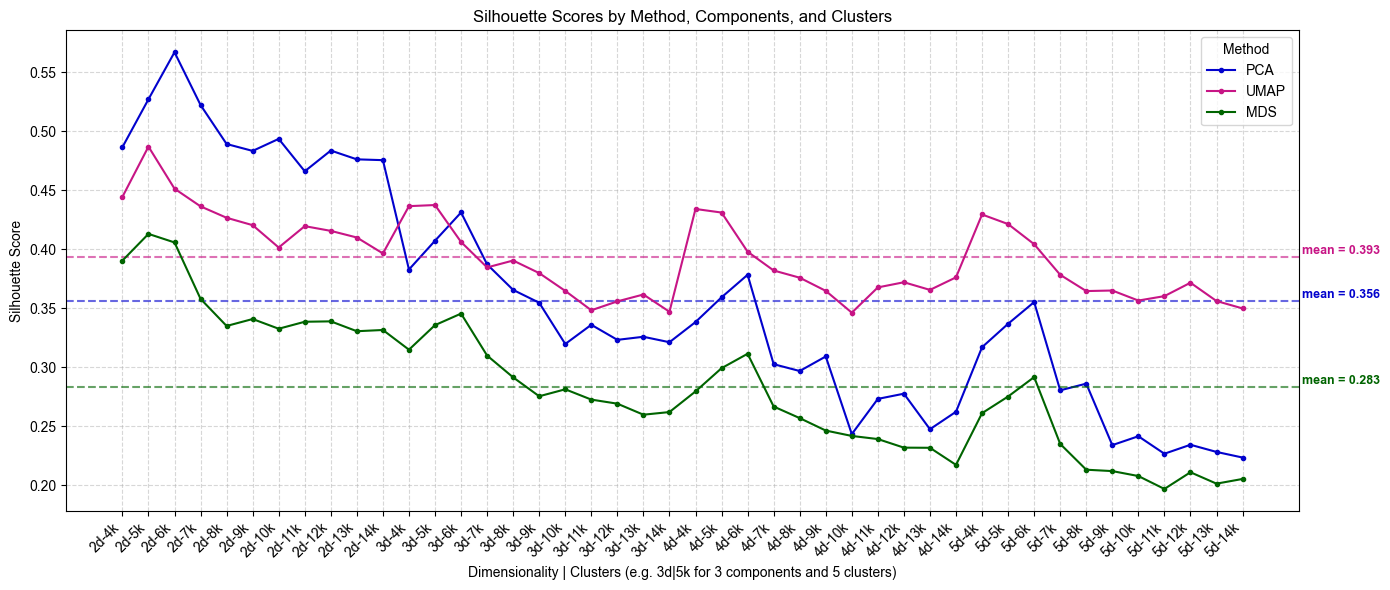

In [10]:
kmeans_results = pd.concat([results_pca, results_umap, results_mds], ignore_index=True)

color_palette = [
            "#0202CD", "#C71585", "#006400"
            ]

import matplotlib.pyplot as plt
# Set the global font family to 'sans-serif'
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['Arial']
    
def plot_clustering_results_by_components_and_k(results_df, color_palette):
    # Sort ascending by n_components then k (left = lowest components & k)
    sorted_df = results_df.sort_values(by=['n_components', 'k'], ascending=[True, True]).copy()
    
    # Create composite x-axis labels
    sorted_df['x_label'] = sorted_df.apply(lambda row: f"{row['n_components']}d-{row['k']}k", axis=1)
    x_labels = sorted_df['x_label'].unique()

    # Map method to color
    methods = sorted_df['method'].unique()
    color_map = dict(zip(methods, color_palette))

    plt.figure(figsize=(14, 6))

    for method in methods:
        subset = sorted_df[sorted_df['method'] == method]
        color = color_map.get(method, 'gray')

        # Plot line for method
        plt.plot(
            subset['x_label'],
            subset['silhouette'],
            marker='.',
            label=method,
            color=color
        )

        # Mean line
        mean_score = subset['silhouette'].mean()
        plt.axhline(mean_score, linestyle='--', color=color, linewidth=1.5, alpha=0.6)

        # Annotation on the far right
        plt.text(
            x=len(x_labels) + 1.3,  # just beyond last tick
            y=mean_score,
            s=f'mean = {mean_score:.3f}',
            color=color,
            fontsize=9, fontweight='bold',
            va='bottom',
            ha='left',
            alpha=1
        )

    plt.title('Silhouette Scores by Method, Components, and Clusters')
    plt.xlabel('Dimensionality | Clusters (e.g. 3d|5k for 3 components and 5 clusters)')
    plt.ylabel('Silhouette Score')
    plt.xticks(ticks=range(len(x_labels)), labels=x_labels, rotation=45, ha='right')
    plt.grid(linestyle='--', alpha=0.5)
    plt.legend(title='Method')
    plt.tight_layout()
    plt.show()

plot_clustering_results_by_components_and_k(kmeans_results, color_palette)

In [11]:
display(kmeans_results)

,method,n_components,k,silhouette
0,PCA,2,4,0.486381
1,PCA,2,5,0.526980
2,PCA,2,6,0.566829
3,PCA,2,7,0.522109
4,PCA,2,8,0.489067
...,...,...,...,...
127,MDS,5,10,0.207695
128,MDS,5,11,0.196765
129,MDS,5,12,0.210901
130,MDS,5,13,0.201240


All dimensionality reduction tehcniques provide high silhouette scores at 2 components and between 5 or 6k.

## GMM

### PCA

In [12]:
from sklearn.decomposition import PCA
from sklearn.mixture import GaussianMixture as GMM
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import silhouette_score

def run_pca_gmm_clustering(X, k_range, dim_range, random_state=19042022):
    print("\nRunning PCA + GMM clustering...\n")
    results = []
    
    # Preprocess the data
    # Drop rows with any missing values across views
    X.dropna(inplace=True)
    X_scaled = RobustScaler().fit_transform(X)
    print(f"Shape of scaled data: {X_scaled.shape}")

    for n_components in dim_range:
        reducer = PCA(n_components=n_components, random_state=random_state)
        X_reduced = reducer.fit_transform(X_scaled)

        for k in k_range:
            gmm = GMM(n_components=k, n_init=100, random_state=random_state)
            labels = gmm.fit_predict(X_reduced)
            score = silhouette_score(X_reduced, labels)

            print(f"PCA | components={n_components} | k={k} | silhouette={score:.4f}")
            results.append({
                'method': 'PCA',
                'n_components': n_components,
                'k': k,
                'silhouette': score
            })

    return pd.DataFrame(results)

results_pca_gmm = run_pca_gmm_clustering(X_combined, k_range, n_range)


Running PCA + GMM clustering...

Shape of scaled data: (81, 34)
PCA | components=2 | k=4 | silhouette=0.4199
PCA | components=2 | k=5 | silhouette=0.1234
PCA | components=2 | k=6 | silhouette=0.2683
PCA | components=2 | k=7 | silhouette=0.3381
PCA | components=2 | k=8 | silhouette=0.3314
PCA | components=2 | k=9 | silhouette=0.3329
PCA | components=2 | k=10 | silhouette=0.1635
PCA | components=2 | k=11 | silhouette=0.0176
PCA | components=2 | k=12 | silhouette=0.0011
PCA | components=2 | k=13 | silhouette=0.2388
PCA | components=2 | k=14 | silhouette=0.0542
PCA | components=3 | k=4 | silhouette=0.0927
PCA | components=3 | k=5 | silhouette=0.1062
PCA | components=3 | k=6 | silhouette=0.1530
PCA | components=3 | k=7 | silhouette=0.1617
PCA | components=3 | k=8 | silhouette=0.1027
PCA | components=3 | k=9 | silhouette=0.0971
PCA | components=3 | k=10 | silhouette=-0.0668
PCA | components=3 | k=11 | silhouette=-0.0239
PCA | components=3 | k=12 | silhouette=-0.0882
PCA | components=3 | k=1

### UMAP

In [13]:
import umap

def run_umap_gmm_clustering(X, k_range, dim_range, random_state=19042022):
    print("\nRunning UMAP + GMM clustering...\n")
    results = []
    
    # Preprocess the data
    # Drop rows with any missing values across views
    X.dropna(inplace=True)
    X_scaled = RobustScaler().fit_transform(X)
    print(f"Shape of scaled data: {X_scaled.shape}")

    for n_components in dim_range:
        reducer = umap.UMAP(n_components=n_components, random_state=random_state)
        X_reduced = reducer.fit_transform(X_scaled)

        for k in k_range:
            gmm = GMM(n_components=k, n_init=100, random_state=random_state)
            labels = gmm.fit_predict(X_reduced)
            score = silhouette_score(X_reduced, labels)

            print(f"UMAP | components={n_components} | k={k} | silhouette={score:.4f}")
            results.append({
                'method': 'UMAP',
                'n_components': n_components,
                'k': k,
                'silhouette': score
            })

    return pd.DataFrame(results)

results_umap_gmm = run_umap_gmm_clustering(X_combined, k_range, n_range)


Running UMAP + GMM clustering...

Shape of scaled data: (81, 34)
UMAP | components=2 | k=4 | silhouette=0.4051
UMAP | components=2 | k=5 | silhouette=0.4352
UMAP | components=2 | k=6 | silhouette=0.3394
UMAP | components=2 | k=7 | silhouette=0.3818
UMAP | components=2 | k=8 | silhouette=0.3398
UMAP | components=2 | k=9 | silhouette=0.3052
UMAP | components=2 | k=10 | silhouette=0.3024
UMAP | components=2 | k=11 | silhouette=0.3256
UMAP | components=2 | k=12 | silhouette=0.3002
UMAP | components=2 | k=13 | silhouette=0.2734
UMAP | components=2 | k=14 | silhouette=0.4041
UMAP | components=3 | k=4 | silhouette=0.4346
UMAP | components=3 | k=5 | silhouette=0.4028
UMAP | components=3 | k=6 | silhouette=0.3519
UMAP | components=3 | k=7 | silhouette=0.3198
UMAP | components=3 | k=8 | silhouette=0.2905
UMAP | components=3 | k=9 | silhouette=0.3005
UMAP | components=3 | k=10 | silhouette=0.3260
UMAP | components=3 | k=11 | silhouette=0.2904
UMAP | components=3 | k=12 | silhouette=0.2615
UMAP |

### MDS

In [14]:
from sklearn.manifold import MDS

def run_mds_gmm_clustering(X, k_range, dim_range, random_state=19042022):
    print("\nRunning MDS + GMM clustering...\n")
    results = []
    
    # Preprocess the data
    # Drop rows with any missing values across views
    X.dropna(inplace=True)
    X_scaled = RobustScaler().fit_transform(X)
    print(f"Shape of scaled data: {X_scaled.shape}")

    for n_components in dim_range:
        reducer = MDS(n_components=n_components, random_state=random_state, n_init=4, max_iter=300)
        X_reduced = reducer.fit_transform(X_scaled)

        for k in k_range:
            gmm = GMM(n_components=k, n_init=100, random_state=random_state)
            labels = gmm.fit_predict(X_reduced)
            score = silhouette_score(X_reduced, labels)

            print(f"MDS  | components={n_components} | k={k} | silhouette={score:.4f}")
            results.append({
                'method': 'MDS',
                'n_components': n_components,
                'k': k,
                'silhouette': score
            })

    return pd.DataFrame(results)

results_mds_gmm = run_mds_gmm_clustering(X_combined, k_range, n_range)


Running MDS + GMM clustering...

Shape of scaled data: (81, 34)
MDS  | components=2 | k=4 | silhouette=0.5915
MDS  | components=2 | k=5 | silhouette=0.3871
MDS  | components=2 | k=6 | silhouette=0.4139
MDS  | components=2 | k=7 | silhouette=0.2745
MDS  | components=2 | k=8 | silhouette=0.2691
MDS  | components=2 | k=9 | silhouette=0.2992
MDS  | components=2 | k=10 | silhouette=0.3232
MDS  | components=2 | k=11 | silhouette=0.2414
MDS  | components=2 | k=12 | silhouette=0.2583
MDS  | components=2 | k=13 | silhouette=0.1742
MDS  | components=2 | k=14 | silhouette=0.3319
MDS  | components=3 | k=4 | silhouette=0.5232
MDS  | components=3 | k=5 | silhouette=0.2509
MDS  | components=3 | k=6 | silhouette=0.3227
MDS  | components=3 | k=7 | silhouette=0.2983
MDS  | components=3 | k=8 | silhouette=0.2664
MDS  | components=3 | k=9 | silhouette=0.2502
MDS  | components=3 | k=10 | silhouette=0.1917
MDS  | components=3 | k=11 | silhouette=0.1840
MDS  | components=3 | k=12 | silhouette=0.1700
MDS  | 

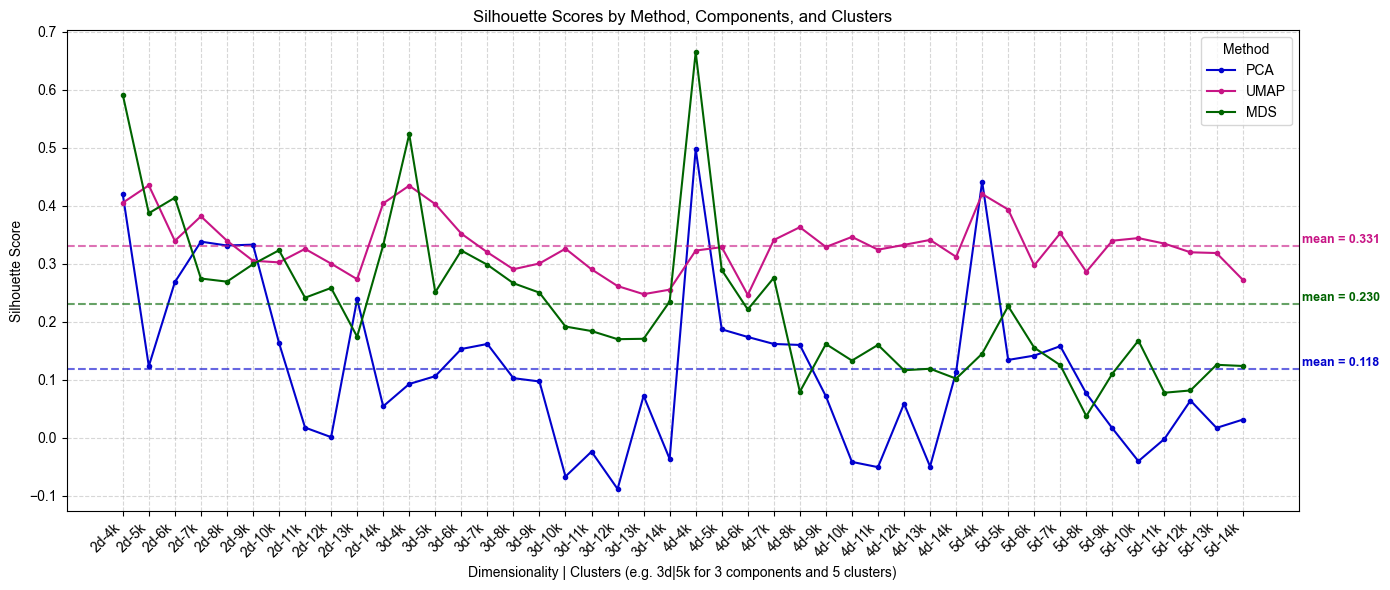

In [15]:
gmm_results = pd.concat([results_pca_gmm, results_umap_gmm, results_mds_gmm], ignore_index=True)

plot_clustering_results_by_components_and_k(gmm_results, color_palette)

## Agglomerative and Spectral Clustering

In [16]:
from sklearn.preprocessing import RobustScaler
from sklearn.decomposition import PCA
from sklearn.manifold import MDS
import umap
from sklearn.cluster import AgglomerativeClustering, SpectralClustering
from sklearn.metrics import silhouette_score
import pandas as pd

# Preprocessing
X = X_combined.copy()
X.dropna(inplace=True)
X_scaled = RobustScaler().fit_transform(X)

# Setup
dim_reduction_methods = ['PCA', 'UMAP', 'MDS']
results = []

# Dimensionality Reduction and Clustering
for method in dim_reduction_methods:
    for n_components in n_range:
        # Apply dimensionality reduction
        if method == 'PCA':
            reducer = PCA(n_components=n_components, random_state=19042022)
        elif method == 'UMAP':
            reducer = umap.UMAP(n_components=n_components, random_state=19042022)
        elif method == 'MDS':
            reducer = MDS(n_components=n_components, random_state=19042022, n_jobs=-1)
        
        X_reduced = reducer.fit_transform(X_scaled)

        for k in k_range:
            # Agglomerative
            try:
                agg = AgglomerativeClustering(n_clusters=k)
                labels_agg = agg.fit_predict(X_reduced)
                sil_agg = silhouette_score(X_reduced, labels_agg)
                print(f"{method}  | components={n_components} | k={k} | silhouette={sil_agg:.4f}")
                results.append({
                    'algorithm': 'Agglomerative',
                    'method': method,
                    'n_components': n_components,
                    'k': k,
                    'silhouette': sil_agg
                })
            except Exception as e:
                print(f"{method}  | components={n_components} | k={k} | Agglomerative failed: {e}")

            # Spectral
            try:
                spec = SpectralClustering(n_clusters=k, affinity='nearest_neighbors', random_state=19042022)
                labels_spec = spec.fit_predict(X_reduced)
                sil_spec = silhouette_score(X_reduced, labels_spec)
                print(f"{method}  | components={n_components} | k={k} | silhouette={sil_spec:.4f}")
                results.append({
                    'algorithm': 'Spectral',
                    'method': method,
                    'n_components': n_components,
                    'k': k,
                    'silhouette': sil_spec
                })
            except Exception as e:
                print(f"{method}  | components={n_components} | k={k} | Spectral failed: {e}")

# Results
agg_spec_results_df = pd.DataFrame(results)


PCA  | components=2 | k=4 | silhouette=0.4877
PCA  | components=2 | k=4 | silhouette=0.3581
PCA  | components=2 | k=5 | silhouette=0.5522
PCA  | components=2 | k=5 | silhouette=0.3194
PCA  | components=2 | k=6 | silhouette=0.5640
PCA  | components=2 | k=6 | silhouette=0.2876
PCA  | components=2 | k=7 | silhouette=0.4647
PCA  | components=2 | k=7 | silhouette=0.3212
PCA  | components=2 | k=8 | silhouette=0.4907
PCA  | components=2 | k=8 | silhouette=0.2685
PCA  | components=2 | k=9 | silhouette=0.4840
PCA  | components=2 | k=9 | silhouette=0.3354
PCA  | components=2 | k=10 | silhouette=0.4923
PCA  | components=2 | k=10 | silhouette=0.3078
PCA  | components=2 | k=11 | silhouette=0.4636
PCA  | components=2 | k=11 | silhouette=0.3404
PCA  | components=2 | k=12 | silhouette=0.4562
PCA  | components=2 | k=12 | silhouette=0.3543
PCA  | components=2 | k=13 | silhouette=0.4488
PCA  | components=2 | k=13 | silhouette=0.3422
PCA  | components=2 | k=14 | silhouette=0.4687
PCA  | components=2 | k=1

In [17]:
# First, add 'algorithm' column to the existing two (if not already present)
kmeans_results['algorithm'] = 'KMeans'
gmm_results['algorithm'] = 'GMM'

# Combine all into one DataFrame
all_results_df = pd.concat([
    kmeans_results,
    gmm_results,
    agg_spec_results_df
], ignore_index=True)


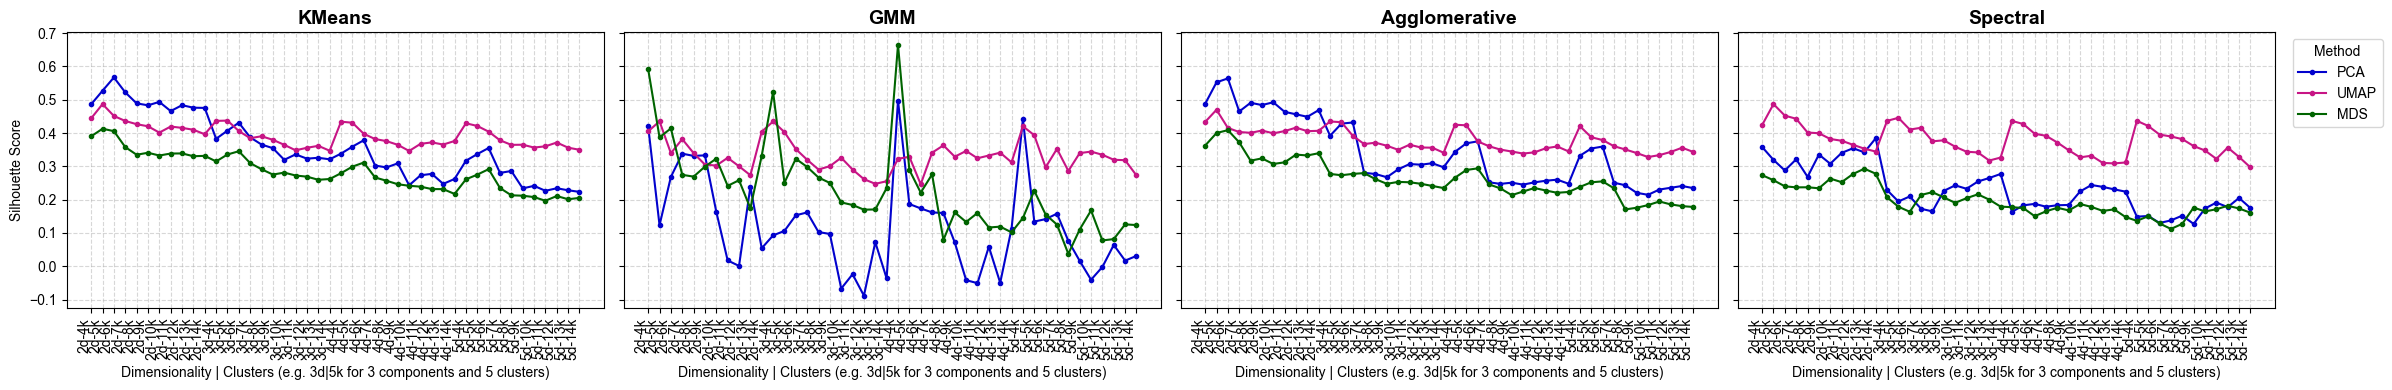

In [18]:
import matplotlib.pyplot as plt

def plot_all_clustering_results_side_by_side(all_results_df, color_palette):
    algorithms = ['KMeans', 'GMM', 'Agglomerative', 'Spectral']
    methods = ['PCA', 'UMAP', 'MDS']
    
    # Map method to color
    color_map = dict(zip(methods, color_palette))
    
    fig, axes = plt.subplots(1, 4, figsize=(24, 4), sharey=True)
    plt.rcParams['font.family'] = 'sans-serif'
    plt.rcParams['font.sans-serif'] = ['Arial']

    for ax, algorithm in zip(axes, algorithms):
        subset_df = all_results_df[all_results_df['algorithm'] == algorithm].copy()
        subset_df.sort_values(by=['n_components', 'k'], ascending=[True, True], inplace=True)
        subset_df['x_label'] = subset_df.apply(lambda row: f"{row['n_components']}d-{row['k']}k", axis=1)
        x_labels = subset_df['x_label'].unique()

        for method in methods:
            method_df = subset_df[subset_df['method'] == method]
            color = color_map.get(method, 'gray')

            ax.plot(
                method_df['x_label'],
                method_df['silhouette'],
                marker='.',
                label=method,
                color=color
            )

        ax.set_title(f"{algorithm}", fontsize=14, fontweight='bold')
        ax.set_xlabel('Dimensionality | Clusters (e.g. 3d|5k for 3 components and 5 clusters)')
        ax.set_xticks(range(len(x_labels)))
        ax.set_xticklabels(x_labels, rotation=90, ha='right')
        ax.grid(linestyle='--', alpha=0.5)

    axes[0].set_ylabel('Silhouette Score')
    axes[-1].legend(title='Method', loc='upper left', bbox_to_anchor=(1.02, 1))

    plt.tight_layout()
    plt.show()

plot_all_clustering_results_side_by_side(all_results_df, color_palette)

# General Observations

* **UMAP** is more consistent but **PCA** yields the highest silhouette score, **MDS** is performing poorly on all algorithms but GMM on some instances.
* **KMeans** and **Agglomerative** produce more stable results.
* **GMM** shows extreme volatility, suggesting instability or poor fit in reduced spaces (especially PCA and MDS).
* All algorithms see a gradual **decline in silhouette** as `k` increases (expected, due to over-fragmentation). The optimal number of components seem to be 2 and the optimal number of k is 4, 5 or 6.

KMeans is indeed the most reliable performer overall in terms of interpretability and shape.

GMM has the least stable and interpretable results across all DR methods.

Agglomerative has similar stability to k-means and performs almost as well, with comparable trends, suggesting it's a strong alternative.

Spectral Clustering is less stable. Since it relies on nearest-neighbor graphs, it's more effective when local structures are preserved — UMAP excels here.

| Algorithm         | Best DR  | Stability   | Max Silhouette | Comment                        |
| ----------------- | -------- | ----------- | -------------- | ------------------------------ |
| **KMeans**        | PCA      | High        | \~0.60         | Most stable, interpretable     |
| **GMM**           | None     | Very Low    | \~0.65 (spike) | Volatile, not robust           |
| **Agglomerative** | PCA/UMAP | High        | \~0.55         | Strong alternative to KMeans   |
| **Spectral**      | UMAP     | Medium-High | \~0.50         | Best for non-linear structures |


In [19]:
# Save results to CSV
all_results_df.to_csv(r"..\Datasets\Final Datasets\clustering_grid_results.csv", index=False)

## DBScan (Ablation)

In [20]:
# import numpy as np
# import matplotlib.pyplot as plt
# from sklearn.neighbors import NearestNeighbors
# from sklearn.preprocessing import RobustScaler

# def plot_k_distance(X, n_components=2, reducer=None, k=5, random_state=19042022):
#     """
#     Plots the sorted distance to the k-th nearest neighbor to help select DBSCAN eps.

#     Parameters:
#     - X: input data (e.g., from get_combined_views_union_dropna)
#     - n_components: number of components for dimensionality reduction
#     - reducer: e.g., PCA, UMAP, MDS
#     - k: min_samples parameter for DBSCAN (k-th neighbor)
#     """
#     # Preprocess the data
#     # Drop rows with any missing values across views
#     X.dropna(inplace=True)
#     X_scaled = RobustScaler().fit_transform(X)

#     if reducer is not None:
#         reducer_instance = reducer(n_components=n_components, random_state=random_state)
#         X_reduced = reducer_instance.fit_transform(X_scaled)
#     else:
#         X_reduced = X_scaled

#     # Fit NearestNeighbors to get k-th neighbor distances
#     nn = NearestNeighbors(n_neighbors=k)
#     nn.fit(X_reduced)
#     distances, _ = nn.kneighbors(X_reduced)

#     # Take the distance to the k-th nearest neighbor
#     k_distances = np.sort(distances[:, k - 1])

#     # Plot
#     plt.figure(figsize=(10, 5))
#     plt.plot(k_distances)
#     plt.title(f'k-Distance Plot (k = {k})')
#     plt.xlabel('Points sorted by distance')
#     plt.ylabel(f'Distance to {k}th nearest neighbor')
#     plt.grid(linestyle='--', alpha=0.5)
#     plt.tight_layout()
#     plt.show()

# from sklearn.decomposition import PCA
# import umap

# # For PCA-reduced data
# plot_k_distance(X_combined, n_components=2, reducer=PCA, k=5)

# # For UMAP-reduced data
# plot_k_distance(X_combined, n_components=3, reducer=umap.UMAP, k=5)

# # Or use raw scaled data without reduction
# plot_k_distance(X_combined, reducer=None, k=5)


In [21]:
# from sklearn.cluster import DBSCAN
# from sklearn.metrics import silhouette_score
# from sklearn.preprocessing import RobustScaler
# from sklearn.decomposition import PCA
# from sklearn.manifold import MDS
# import umap

# def run_dbscan_clustering(X, reducer_name, reducer_fn, dim_range, eps_range, min_samples=5, random_state=19042022):
#     print(f"\nRunning {reducer_name} + DBSCAN clustering...\n")
#     results = []
#     # Preprocess the data
#     # Drop rows with any missing values across views
#     X.dropna(inplace=True)
#     X_scaled = RobustScaler().fit_transform(X)

#     for n_components in dim_range:
#         reducer = reducer_fn(n_components=n_components, random_state=random_state)
#         X_reduced = reducer.fit_transform(X_scaled)

#         for eps in eps_range:
#             dbscan = DBSCAN(eps=eps, min_samples=min_samples)
#             labels = dbscan.fit_predict(X_reduced)
#             n_clusters = len(set(labels)) - (1 if -1 in labels else 0)

#             if n_clusters >= 2:
#                 score = silhouette_score(X_reduced, labels)
#                 print(f"{reducer_name} | components={n_components} | eps={eps:.2f} | clusters={n_clusters} | silhouette={score:.4f}")
#                 results.append({
#                     'method': reducer_name,
#                     'n_components': n_components,
#                     'eps': eps,
#                     'n_clusters': n_clusters,
#                     'silhouette': score
#                 })
#             else:
#                 print(f"{reducer_name} | components={n_components} | eps={eps:.2f} | clusters={n_clusters} → skipped")

#     return pd.DataFrame(results)

In [22]:
# eps_range = [0.3, 0.4, 0.5, 0.6, 0.8, 1.0, 1.2, 1.5, 2.0]
# results_pca_dbscan = run_dbscan_clustering(
#     X_combined,
#     reducer_name='PCA',
#     reducer_fn=PCA,
#     dim_range=n_range,
#     eps_range=eps_range
# )

In [23]:
# eps_range = [0.5, 0.6, 0.7, 0.8, 0.9]
# results_umap_dbscan = run_dbscan_clustering(
#     X_combined,
#     reducer_name='UMAP',
#     reducer_fn=umap.UMAP,
#     dim_range=n_range,
#     eps_range=eps_range
# )

# Sensitivity over random seed

In [24]:
import numpy as np
import pandas as pd
import random
import itertools
from sklearn.preprocessing import RobustScaler
from sklearn.decomposition import PCA
from sklearn.manifold import MDS
import umap
from sklearn.cluster import KMeans, AgglomerativeClustering, SpectralClustering
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score, adjusted_rand_score, normalized_mutual_info_score

# Preprocessing
X = X_combined.copy()
X.dropna(inplace=True)
X_scaled = RobustScaler().fit_transform(X)

# Config
dim_reduction_methods = ['PCA', 'UMAP', 'MDS']
clustering_algorithms = ['KMeans', 'GMM', 'Agglomerative', 'Spectral']
k_range = [4, 5, 6]
n_components = 2

# Fixed 100 seeds
random.seed(19042022)
random_range = random.sample(range(1000, 10000), 100)

# Run clustering and store results
run_records = []
label_store = {}  # (method, algorithm, k) → list of (seed, labels)

for seed in random_range:
    print(f"\n=== Seed {seed} ===")

    for method in dim_reduction_methods:
        # Dimensionality reduction
        if method == 'PCA':
            reducer = PCA(n_components=n_components, random_state=seed)
        elif method == 'UMAP':
            reducer = umap.UMAP(n_components=n_components, random_state=seed)
        elif method == 'MDS':
            reducer = MDS(n_components=n_components, random_state=seed, n_jobs=-1)

        X_reduced = reducer.fit_transform(X_scaled)

        for k in k_range:
            for algo in clustering_algorithms:
                try:
                    if algo == 'KMeans':
                        model = KMeans(n_clusters=k, random_state=seed, n_init=10)
                        labels = model.fit_predict(X_reduced)
                    elif algo == 'GMM':
                        model = GaussianMixture(n_components=k, random_state=seed, n_init=5)
                        labels = model.fit_predict(X_reduced)
                    elif algo == 'Agglomerative':
                        model = AgglomerativeClustering(n_clusters=k)
                        labels = model.fit_predict(X_reduced)
                    elif algo == 'Spectral':
                        model = SpectralClustering(n_clusters=k, affinity='nearest_neighbors', random_state=seed)
                        labels = model.fit_predict(X_reduced)

                    if len(set(labels)) > 1:
                        sil = silhouette_score(X_reduced, labels)
                        print(f"{method} | {algo} | k={k} | seed={seed} | silhouette={sil:.4f}")

                        run_records.append({
                            'method': method,
                            'algorithm': algo,
                            'k': k,
                            'seed': seed,
                            'silhouette': sil
                        })

                        key = (method, algo, k)
                        label_store.setdefault(key, []).append((seed, labels))
                    else:
                        print(f"{method} | {algo} | k={k} | seed={seed} → only 1 cluster")

                except Exception as e:
                    print(f"{method} | {algo} | k={k} | seed={seed} → failed: {e}")

# Store silhouette scores
silhouette_df = pd.DataFrame(run_records)

# Compute all pairwise ARI/NMI scores per method/algorithm/k
max_seed_pairs = 10  # Reduce labelings per (method, algo, k) key to avoid explosion of pairs
ari_nmi_records = []

for key, label_list in label_store.items():
    method, algo, k = key

    # Subsample labelings per key
    if len(label_list) > max_seed_pairs:
        label_list = random.sample(label_list, max_seed_pairs)

    # Pairwise comparisons
    for (seed1, labels1), (seed2, labels2) in itertools.combinations(label_list, 2):
        labels1 = np.asarray(labels1)
        labels2 = np.asarray(labels2)

        # Skip comparisons with degenerate clustering (e.g., 1 cluster only)
        if len(set(labels1)) < 2 or len(set(labels2)) < 2:
            continue

        try:
            ari = adjusted_rand_score(labels1, labels2)
            nmi = normalized_mutual_info_score(labels1, labels2)
        except Exception as e:
            print(f"[{key}] Seed pair ({seed1}, {seed2}) → failed: {e}")
            continue

        ari_nmi_records.append({
            'method': method,
            'algorithm': algo,
            'k': k,
            'seed_1': seed1,
            'seed_2': seed2,
            'ARI': ari,
            'NMI': nmi
        })

# Convert to long-form DataFrame
stability_ari_nmi_df = pd.DataFrame(ari_nmi_records)


=== Seed 3016 ===
PCA | KMeans | k=4 | seed=3016 | silhouette=0.4864
PCA | GMM | k=4 | seed=3016 | silhouette=0.4199
PCA | Agglomerative | k=4 | seed=3016 | silhouette=0.4877
PCA | Spectral | k=4 | seed=3016 | silhouette=0.3581
PCA | KMeans | k=5 | seed=3016 | silhouette=0.5270
PCA | GMM | k=5 | seed=3016 | silhouette=0.2808
PCA | Agglomerative | k=5 | seed=3016 | silhouette=0.5522
PCA | Spectral | k=5 | seed=3016 | silhouette=0.3194
PCA | KMeans | k=6 | seed=3016 | silhouette=0.5680
PCA | GMM | k=6 | seed=3016 | silhouette=0.3450
PCA | Agglomerative | k=6 | seed=3016 | silhouette=0.5640
PCA | Spectral | k=6 | seed=3016 | silhouette=0.2876
UMAP | KMeans | k=4 | seed=3016 | silhouette=0.4551
UMAP | GMM | k=4 | seed=3016 | silhouette=0.4535
UMAP | Agglomerative | k=4 | seed=3016 | silhouette=0.4245
UMAP | Spectral | k=4 | seed=3016 | silhouette=0.4551
UMAP | KMeans | k=5 | seed=3016 | silhouette=0.4793
UMAP | GMM | k=5 | seed=3016 | silhouette=0.3640
UMAP | Agglomerative | k=5 | seed=30

In [25]:
display(stability_ari_nmi_df)
stability_ari_nmi_df.to_csv(r"..\Datasets\Final Datasets\stability_ari_nmi_results.csv",
                                   index=False)
silhouette_df.to_csv(r"..\Datasets\Final Datasets\clustering_grid_results.csv",
                            index=False)

,method,algorithm,k,seed_1,seed_2,ARI,NMI
0,PCA,KMeans,4,9855,5791,1.000000,1.000000
1,PCA,KMeans,4,9855,2407,1.000000,1.000000
2,PCA,KMeans,4,9855,3735,1.000000,1.000000
3,PCA,KMeans,4,9855,9513,1.000000,1.000000
4,PCA,KMeans,4,9855,9149,1.000000,1.000000
...,...,...,...,...,...,...,...
1615,MDS,Spectral,6,9181,4861,0.854299,0.875956
1616,MDS,Spectral,6,9181,9213,0.691183,0.766715
1617,MDS,Spectral,6,9496,4861,0.856354,0.911481
1618,MDS,Spectral,6,9496,9213,0.587214,0.693301


In [26]:
stability_ari_nmi_df = pd.read_csv(r"..\Datasets\Final Datasets\stability_ari_nmi_results.csv")
silhouette_df = pd.read_csv(r"..\Datasets\Final Datasets\clustering_grid_results.csv")

In [27]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Define method colors
method_colors = {
    'PCA': '#0202CD',
    'UMAP': '#C71585',
    'MDS': '#006400'
}

method_order = ['PCA', 'UMAP', 'MDS']
algorithm_order = ['KMeans', 'GMM', 'Agglomerative', 'Spectral']

def plot_boxplots_with_left_strip(metric_df, metric_name, y_label):
    fig, axes = plt.subplots(1, 4, figsize=(20, 4), sharey=True)
    fig.suptitle(f'{y_label} Distribution by Method and Algorithm', fontsize=16, fontweight='bold')

    for i, algorithm in enumerate(algorithm_order):
        ax = axes[i]
        subset = metric_df[metric_df['algorithm'] == algorithm]

        # Get numeric positions for each method
        positions = np.arange(len(method_order))

        # Plot boxplots with no fill and colored edges
        for j, method in enumerate(method_order):
            method_data = subset[subset['method'] == method][metric_name].values
            if len(method_data) == 0:
                continue
            bp = ax.boxplot(
                method_data,
                positions=[j + 0.2],  # slight right shift
                widths=0.3,
                patch_artist=True,
                boxprops=dict(facecolor='none', color=method_colors[method], linewidth=2),
                capprops=dict(color=method_colors[method], linewidth=2),
                whiskerprops=dict(color=method_colors[method], linewidth=2),
                flierprops=dict(marker='o', color=method_colors[method], alpha=0.3),
                medianprops=dict(color=method_colors[method], linewidth=2)
            )

            # Plot stripplot (scatter) to the **left** of the boxplot
            jittered_x = np.random.normal(j - 0.2, 0.03, size=len(method_data))
            ax.scatter(jittered_x, method_data,
                       color=method_colors[method],
                       alpha=0.6,
                       s=20,
                       edgecolor='gray',
                       linewidth=0.4)

        ax.set_xticks(positions)
        ax.set_xticklabels(method_order, rotation=45)
        ax.set_title(algorithm, fontsize=14, fontweight='bold')
        ax.set_xlabel('')
        if i == 0:
            ax.set_ylabel(y_label)
        else:
            ax.set_ylabel('')

    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

In [28]:
stability_ari_nmi_df

,method,algorithm,k,seed_1,seed_2,ARI,NMI
0,PCA,KMeans,4,9855,5791,1.000000,1.000000
1,PCA,KMeans,4,9855,2407,1.000000,1.000000
2,PCA,KMeans,4,9855,3735,1.000000,1.000000
3,PCA,KMeans,4,9855,9513,1.000000,1.000000
4,PCA,KMeans,4,9855,9149,1.000000,1.000000
...,...,...,...,...,...,...,...
1615,MDS,Spectral,6,9181,4861,0.854299,0.875956
1616,MDS,Spectral,6,9181,9213,0.691183,0.766715
1617,MDS,Spectral,6,9496,4861,0.856354,0.911481
1618,MDS,Spectral,6,9496,9213,0.587214,0.693301


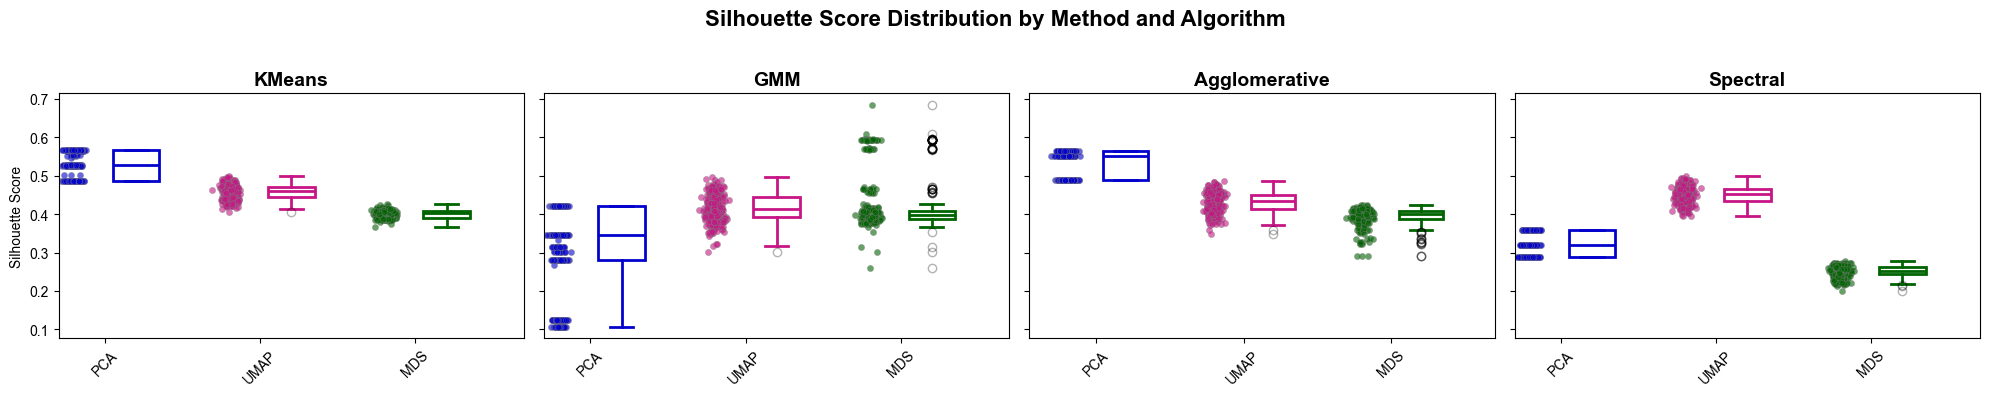

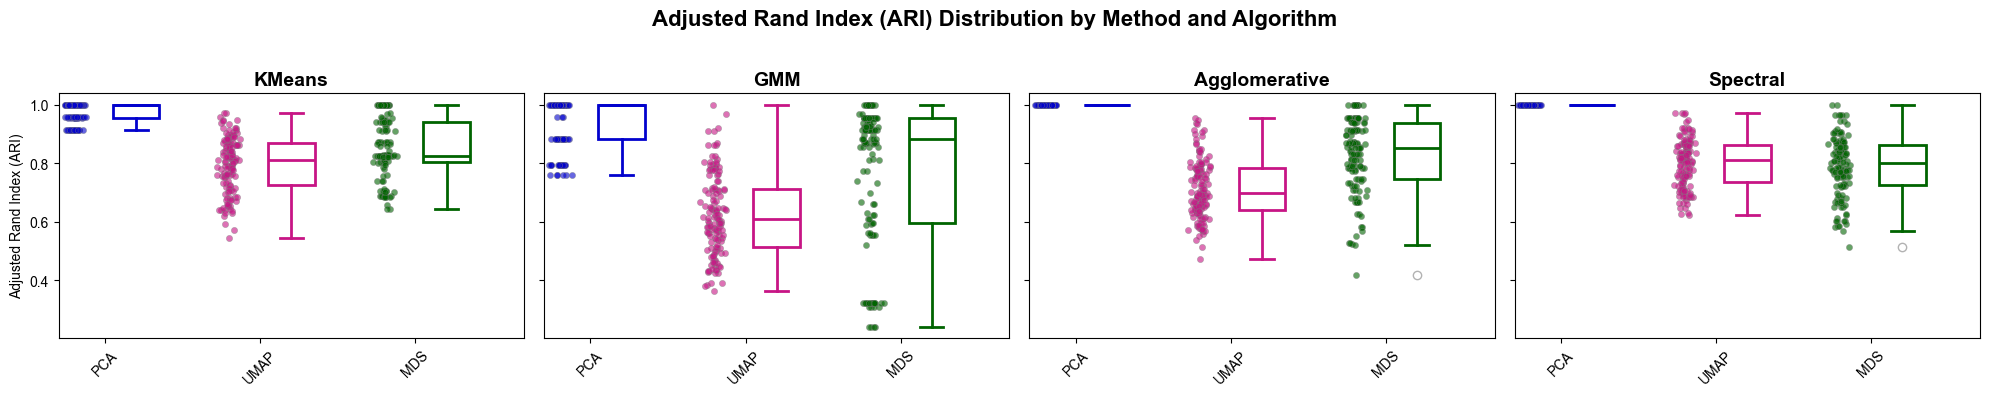

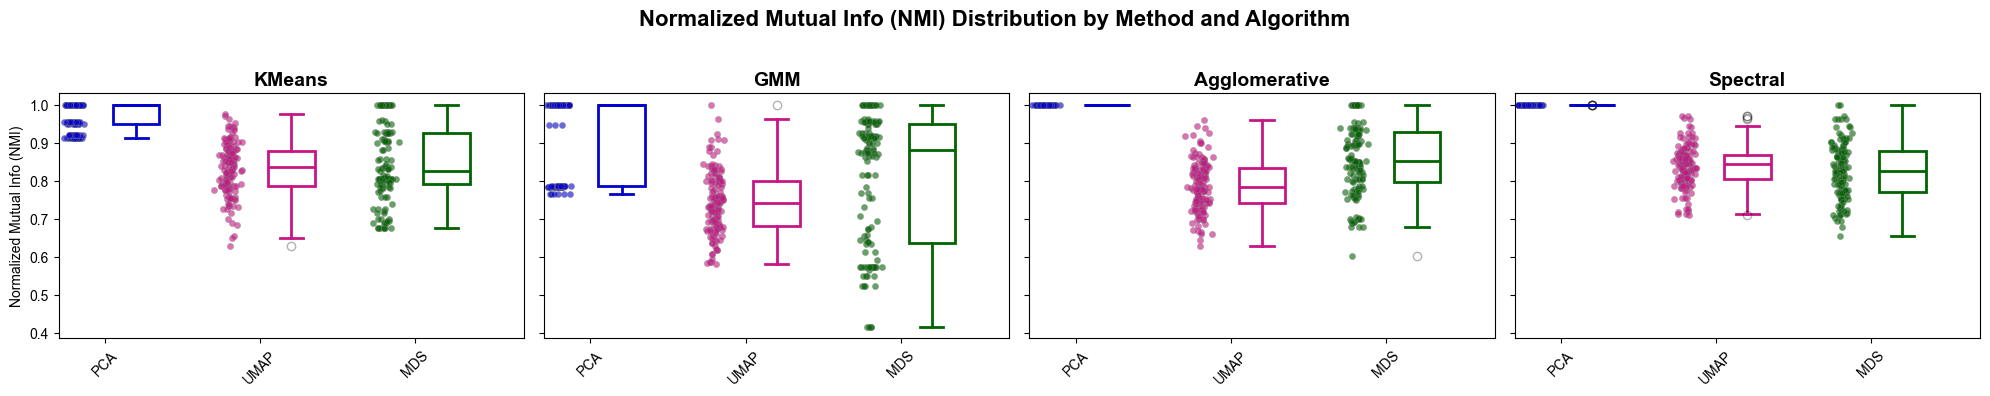

In [29]:
plot_boxplots_with_left_strip(silhouette_df, metric_name='silhouette', y_label='Silhouette Score')
plot_boxplots_with_left_strip(stability_ari_nmi_df, metric_name='ARI', y_label='Adjusted Rand Index (ARI)')
plot_boxplots_with_left_strip(stability_ari_nmi_df, metric_name='NMI', y_label='Normalized Mutual Info (NMI)')